# -------------------------------------------
# CLUSTERING DE PERFILES DE RIESGO - VEHÍCULOS
# -------------------------------------------


## Importar Librerías

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import joblib   # Para guardar el modelo


## Cargar Dataset preprocesado

In [56]:
# Ruta al archivo ya preprocesado (sin nulos ni outliers)
df = pd.read_csv('../Data/motor_data_2011_2018_pre.csv')

# Eliminamos la columna innecesaria Unnamed: 0 si existe
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)

# Vista previa de los datos
df.head()



,OBJECT_ID,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID,HAS_CLAIM
0,5000029885,0,2013-08-08,2014-08-07,2008.0,1202,519755.22,7209.140,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
1,5000029885,0,2012-08-08,2013-08-07,2008.0,1202,519755.22,7203.890,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
2,5000029885,0,2011-08-08,2012-08-07,2008.0,1202,519755.22,7045.804,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
3,5000029885,0,2011-07-08,2011-08-07,2008.0,1202,519755.22,287.250,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
4,5000029901,0,2013-08-08,2014-08-07,2008.0,1202,285451.24,4286.900,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43,1


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801838 entries, 0 to 801837
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OBJECT_ID          801838 non-null  int64  
 1   SEX                801838 non-null  int64  
 2   INSR_BEGIN         801838 non-null  object 
 3   INSR_END           801838 non-null  object 
 4   EFFECTIVE_YR       801838 non-null  float64
 5   INSR_TYPE          801838 non-null  int64  
 6   INSURED_VALUE      801838 non-null  float64
 7   PREMIUM            801838 non-null  float64
 8   PROD_YEAR          801838 non-null  float64
 9   SEATS_NUM          801838 non-null  float64
 10  CARRYING_CAPACITY  801838 non-null  float64
 11  TYPE_VEHICLE       801838 non-null  object 
 12  CCM_TON            801838 non-null  float64
 13  MAKE               801838 non-null  object 
 14  USAGE              801838 non-null  object 
 15  CLAIM_PAID         801838 non-null  float64
 16  HA

## Selección de las variables para el clustering

In [58]:
# Selección de variables numéricas y categóricas relevantes
features = ['SEX', 'INSURED_VALUE', 'PREMIUM', 'SEATS_NUM', 
            'CARRYING_CAPACITY', 'CCM_TON', 'MAKE', 'USAGE', 'CLAIM_PAID']

df_clust = df[features]

# Verificamos tipos de datos
df_clust.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801838 entries, 0 to 801837
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEX                801838 non-null  int64  
 1   INSURED_VALUE      801838 non-null  float64
 2   PREMIUM            801838 non-null  float64
 3   SEATS_NUM          801838 non-null  float64
 4   CARRYING_CAPACITY  801838 non-null  float64
 5   CCM_TON            801838 non-null  float64
 6   MAKE               801838 non-null  object 
 7   USAGE              801838 non-null  object 
 8   CLAIM_PAID         801838 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 55.1+ MB


## Preprocesamiento: Categorización y Escalado

In [59]:
# Separación de variables categóricas y numéricas
cat_features = ['MAKE', 'USAGE']
num_features = ['SEX', 'INSURED_VALUE', 'PREMIUM', 'SEATS_NUM', 
                'CARRYING_CAPACITY', 'CCM_TON', 'CLAIM_PAID']

# Definimos el preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Pipeline de preprocesamiento
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicamos transformación
X_processed = pipeline.fit_transform(df_clust)

# Confirmamos forma final de los datos
X_processed.shape


(801838, 36)

## Determinar Número Óptimo de Clústeres (Método del Codo)

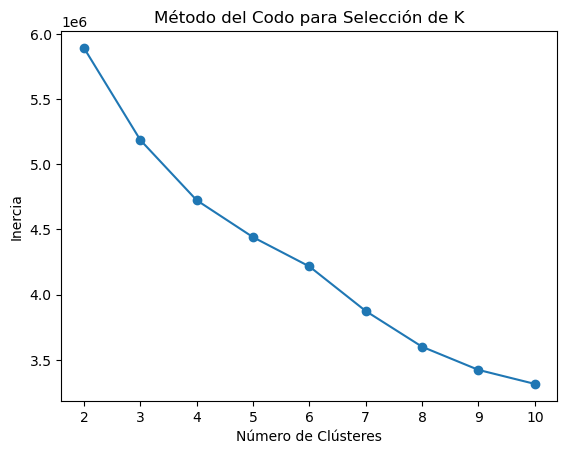

In [60]:
# Método del Codo
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# Graficamos el codo
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo para Selección de K')
plt.show()


## Aplicar K-Means Clustering

In [61]:
# Suponiendo que el codo sugiere 4 clústeres (ajusta según gráfico)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_processed)

# Añadimos el clúster al dataframe original
df_clust['Cluster'] = clusters

# Vista previa
df_clust.head()


/var/folders/s8/l3j5zms14s71b3h4v6d7qkl00000gn/T/ipykernel_21490/218871637.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust['Cluster'] = clusters


,SEX,INSURED_VALUE,PREMIUM,SEATS_NUM,CARRYING_CAPACITY,CCM_TON,MAKE,USAGE,CLAIM_PAID,Cluster
0,0,519755.22,7209.140,4.0,6.0,3153.0,NISSAN,Own Goods,0.00,2
1,0,519755.22,7203.890,4.0,6.0,3153.0,NISSAN,Own Goods,0.00,2
2,0,519755.22,7045.804,4.0,6.0,3153.0,NISSAN,Own Goods,0.00,2
3,0,519755.22,287.250,4.0,6.0,3153.0,NISSAN,Own Goods,0.00,2
4,0,285451.24,4286.900,4.0,7.0,2494.0,TOYOTA,Own Goods,19894.43,2


## Análisis de Perfiles por Clúster

In [62]:
# Perfil promedio por clúster
cluster_profile = df_clust.groupby('Cluster').mean(numeric_only=True)
cluster_profile


,SEX,INSURED_VALUE,PREMIUM,SEATS_NUM,CARRYING_CAPACITY,CCM_TON,CLAIM_PAID
Cluster,,,,,,,
0,1.000000,1.099012e+05,2880.436862,3.573715,5.573361,1682.447739,6776.099964
1,0.255106,6.725969e+05,9919.212487,2.076930,17.226883,5612.261451,15570.531805
2,0.000000,4.615714e+05,5425.340343,3.862994,6.377682,2712.124522,9695.888513
3,0.542345,1.925733e+06,28778.860899,2.198623,4.103213,7521.290414,112091.913907


## Visualización con PCA

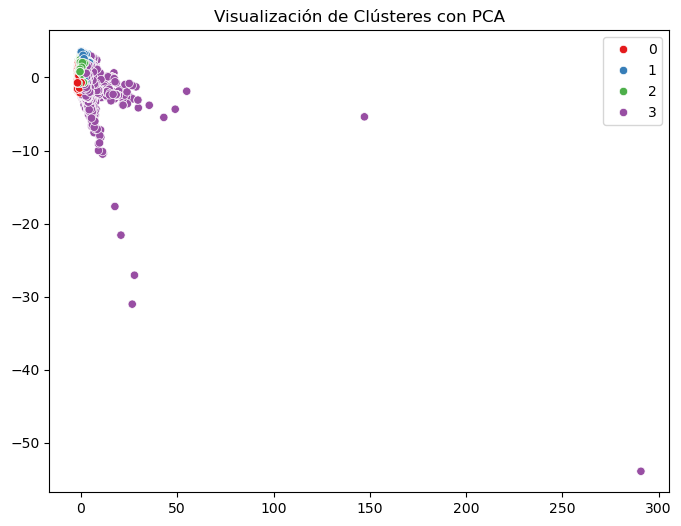

In [63]:
# Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)


# Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set1')
plt.title('Visualización de Clústeres con PCA')
plt.show()

## Clustering con filtro de riesgo normal
- se crear categorias de nivel de riesgo normal y high risk en el preprocesado con Z-Score para quitar los outliers
- Se filtra solo los de categoria normal
- Se calcula el numero de segmentaciones optimas K=5
- Se entrena con K-means

In [64]:
# Ruta al archivo ya preprocesado (sin nulos ni outliers)
df = pd.read_csv('../Data/motor_data_2011_2018_RISK.csv')

# Eliminamos la columna innecesaria Unnamed: 0 si existe
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)

# Vista previa de los datos
df.head()

,OBJECT_ID,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID,HAS_CLAIM,RISK_CATEGORY
0,5000029885,0,2013-08-08,2014-08-07,2008.0,1202,519755.22,7209.140,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal
1,5000029885,0,2012-08-08,2013-08-07,2008.0,1202,519755.22,7203.890,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal
2,5000029885,0,2011-08-08,2012-08-07,2008.0,1202,519755.22,7045.804,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal
3,5000029885,0,2011-07-08,2011-08-07,2008.0,1202,519755.22,287.250,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal
4,5000029901,0,2013-08-08,2014-08-07,2008.0,1202,285451.24,4286.900,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43,1,Normal


✅ Código Completo para Filtrar y Entrenar con K-Means

In [65]:
# 1️⃣ Filtrar datos sin los de "Very High" riesgo
df_cluster = df[df['RISK_CATEGORY'] == 'Normal'].copy()

# 2️⃣ Definir variables para clustering
features = ['SEX', 'INSURED_VALUE', 'PREMIUM', 'SEATS_NUM', 
            'CARRYING_CAPACITY', 'CCM_TON', 'MAKE', 'USAGE', 'CLAIM_PAID']

cat_features = ['MAKE', 'USAGE']
num_features = ['SEX', 'INSURED_VALUE', 'PREMIUM', 'SEATS_NUM', 
                'CARRYING_CAPACITY', 'CCM_TON', 'CLAIM_PAID']

# 3️⃣ Pipeline de preprocesamiento
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
# 4️⃣ Aplicar preprocesamiento
X_processed = pipeline.fit_transform(df_cluster)

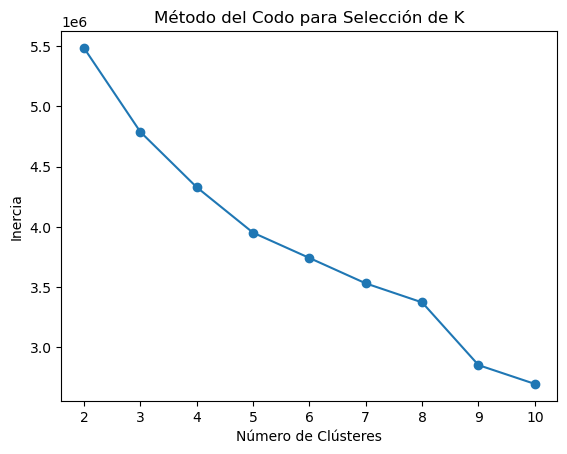

In [66]:
# Método del Codo
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# Graficamos el codo
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo para Selección de K')
plt.show()

Modelo K-Means y pipeline guardados exitosamente.


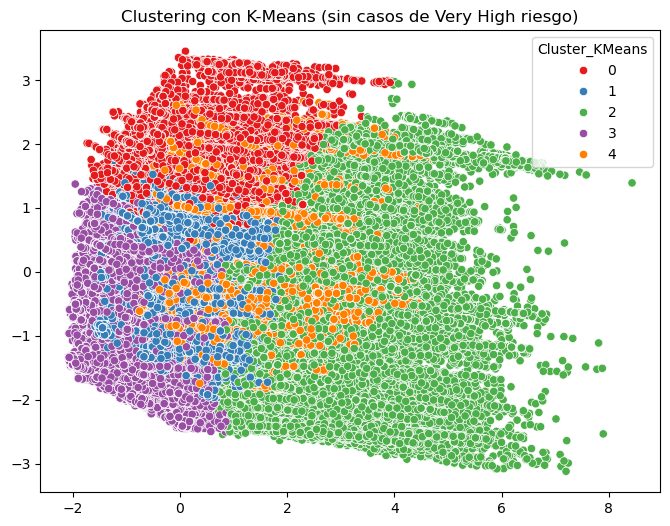

Cluster_KMeans
1    275490
3    244564
0     96825
4     87089
2     80833
Name: count, dtype: int64


In [67]:
# 5️⃣ Definir y entrenar K-Means (ajusta K si es necesario)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_processed)

# 6️⃣ Añadir los clústeres al DataFrame
df_cluster['Cluster_KMeans'] = clusters

# 7️⃣ Visualización con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Agregar las columnas de PCA al dataframe original
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

# Guardar el modelo K-Means entrenado
joblib.dump(kmeans, '../Modelos/kmeans_model.pkl')

# Guardar el pipeline de preprocesamiento
joblib.dump(pipeline, '../Modelos/preprocessing_pipeline.pkl')

# Guardar el objeto PCA
joblib.dump(pca, '../Modelos/pca_model.pkl')

print("Modelo K-Means y pipeline guardados exitosamente.")

# Visualización de los clústeres
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_cluster['Cluster_KMeans'], palette='Set1')
plt.title('Clustering con K-Means (sin casos de Very High riesgo)')
plt.show()

# 8️⃣ Conteo de clústeres
print(df_cluster['Cluster_KMeans'].value_counts())


In [68]:
df_cluster.head()

,OBJECT_ID,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,PROD_YEAR,SEATS_NUM,...,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID,HAS_CLAIM,RISK_CATEGORY,Cluster_KMeans,PCA1,PCA2
0,5000029885,0,2013-08-08,2014-08-07,2008.0,1202,519755.22,7209.140,2007.0,4.0,...,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal,1,0.279548,0.287416
1,5000029885,0,2012-08-08,2013-08-07,2008.0,1202,519755.22,7203.890,2007.0,4.0,...,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal,1,0.279215,0.287447
2,5000029885,0,2011-08-08,2012-08-07,2008.0,1202,519755.22,7045.804,2007.0,4.0,...,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal,1,0.269178,0.288388
3,5000029885,0,2011-07-08,2011-08-07,2008.0,1202,519755.22,287.250,2007.0,4.0,...,Pick-up,3153.0,NISSAN,Own Goods,0.00,0,Normal,1,-0.159924,0.328610
4,5000029901,0,2013-08-08,2014-08-07,2008.0,1202,285451.24,4286.900,2010.0,4.0,...,Pick-up,2494.0,TOYOTA,Own Goods,19894.43,1,Normal,1,-0.148149,0.651967


In [69]:

variables_numericas = ['INSURED_VALUE', 'PREMIUM', 'SEATS_NUM', 'CARRYING_CAPACITY', 'CCM_TON', 'CLAIM_PAID']
variables_categoricas = ['MAKE', 'USAGE']

perfil_numerico = df_cluster.groupby('Cluster_KMeans')[variables_numericas].mean().round(2)

perfil_categorico = {}
for var in variables_categoricas:
    perfil_categorico[var] = df_cluster.groupby('Cluster_KMeans')[var].value_counts(normalize=True).unstack().round(3)


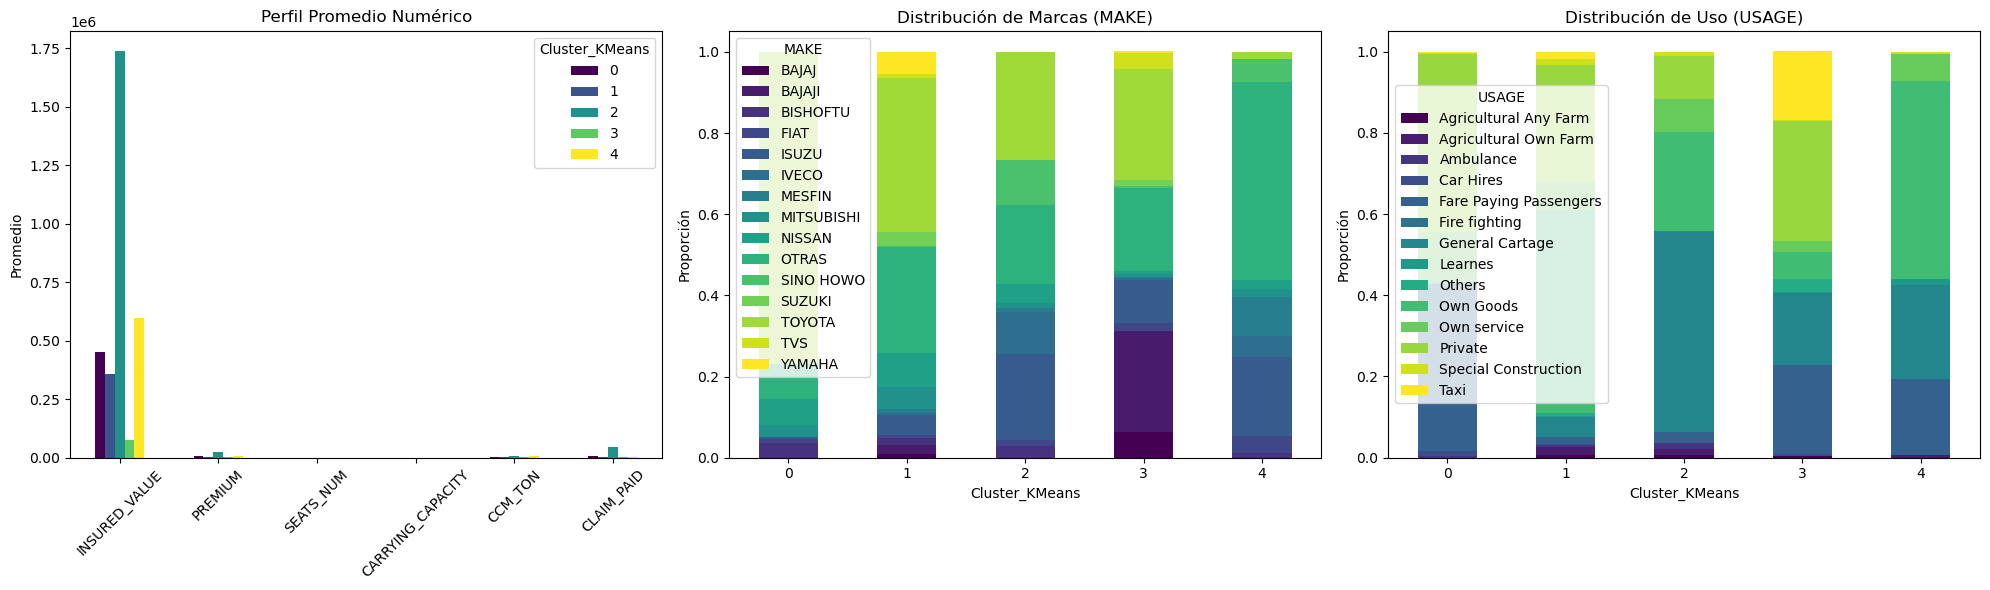

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico de variables numéricas
perfil_numerico.T.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Perfil Promedio Numérico')
axes[0].set_ylabel('Promedio')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico MAKE
perfil_categorico['MAKE'].plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Distribución de Marcas (MAKE)')
axes[1].set_ylabel('Proporción')
axes[1].tick_params(axis='x', rotation=0)

# Gráfico USAGE
perfil_categorico['USAGE'].plot(kind='bar', stacked=True, ax=axes[2], colormap='viridis')
axes[2].set_title('Distribución de Uso (USAGE)')
axes[2].set_ylabel('Proporción')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [71]:
# Se guarda el DataFrame df_cluster completo con las columnas:
# - Todas las variables originales
# - 'RISK_CATEGORY' (Normal o Very High)
# - 'Cluster_KMeans' (para los "Normal y los Very High")


df['Cluster_KMeans'] = np.nan
df['PCA1'] = np.nan
df['PCA2'] = np.nan

df.loc[df['RISK_CATEGORY'] == 'Normal', 'PCA1'] = df_cluster['PCA1']
df.loc[df['RISK_CATEGORY'] == 'Normal', 'PCA2'] = df_cluster['PCA2']
df.loc[df['RISK_CATEGORY'] == 'Normal', 'Cluster_KMeans'] = df_cluster['Cluster_KMeans']

# Guardar a CSV
df.to_csv('../Data/motor_data_final_para_powerbi.csv', index_label='OBJECT_ID')
